In [1]:
import dlc_bci as bci

import os

import torch
import numpy as np
from matplotlib.pylab import plt

from models import *
from callbacks import keep_best_model, store_best_model

from types import SimpleNamespace 

import torch 
from torch import optim
from torch import nn

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
# seed not working ...
torch.manual_seed(1)
model2 = CNN_1D_MaxPool(**params)
model2.to(device)

torch.manual_seed(1)
model1 = CNN_1D_MaxPool(**params)
model1.to(device)

p1 = model1.parameters()
p2 = model2.parameters()
for p in p1:
    print((p == next(p2)).all())
model1(X_tr[:1]), model2(X_tr[:1])

In [ ]:
grid_search_on=[
        ("nb_layers", list(range(1, 7))),
        ("nb_hidden", [np.asscalar(n) for n in np.arange(40, 201, 40)]),
        ("activation", [nn.ReLU, nn.Tanh, nn.ELU]),
        ("weight_decay", [0] + [np.asscalar(wd) for wd in np.logspace(-6, -2, 5, base=np.e)]),
        ("dropout", [np.asscalar(d) for d in np.linspace(0, 0.30, 4)]),
        ("optimizer", [optim.Adam, optim.Adadelta, optim.Adamax]),
        ("nb_layers", list(range(1, 7)))
    ]

### Load data

In [2]:
one_khz=False

train = SimpleNamespace()
train.X, train.y = bci.load(root='./data_bci', one_khz=one_khz)
print(str(type(train.X)), train.X.size())
print(str(type(train.y)), train.y.size())

test = SimpleNamespace()
test.X, test.y = bci.load(root='./data_bci', train=False, one_khz=one_khz)
print(str(type(test.X)), test.X.size())
print(str(type(test.y)), test.y.size())

<class 'torch.Tensor'> torch.Size([316, 28, 50])
<class 'torch.Tensor'> torch.Size([316])
<class 'torch.Tensor'> torch.Size([100, 28, 50])
<class 'torch.Tensor'> torch.Size([100])


In [6]:
def load_best_params_and_scores(model):
    model_path =  model().dir_path
    
    # load best params
    params = torch.load(model_path + "/cross_validation" + "/best_params_")

    # load cross validation scores
    scores = torch.load(model_path + "/cross_validation/scores/nb_layers")
    crossval_scores = scores["va_scores"][params["nb_layers"]-1]

    return params, crossval_scores

### Train the model on the best parameters and compute the test accuracy

In [100]:
cross_val_scores = {}

- `CNN2D_MaxPool`

In [101]:
params, crossval_scores = load_best_params_and_scores(CNN2D_MaxPool)
cross_val_scores["2D CNN"] = crossval_scores

params, crossval_scores

({'activation': torch.nn.modules.activation.ELU,
  'dropout': 0.0,
  'nb_hidden': 80,
  'nb_layers': 3,
  'optimizer': torch.optim.adadelta.Adadelta,
  'weight_decay': 0.0024787521766663594},
 [0.71875,
  0.7301587301587301,
  0.8095238095238095,
  0.7619047619047619,
  0.7936507936507936])

In [39]:
X_tr, y_tr = CNN2D_MaxPool.prepare_data(train)
X_tr, y_tr = X_tr.to(device), y_tr.to(device)

X_te, y_te = CNN2D_MaxPool.prepare_data(test)
X_te, y_te = X_te.to(device), y_te.to(device)

model = CNN2D_MaxPool(**params)
model.to(device)

model.fit(X_tr, y_tr, X_te, y_te, epochs=30, callbacks=[keep_best_model], verbose=False)
print("Test score:", model.score(X_te, y_te))

/cvlabdata1/home/sacchi/others/predict-finger-movement/modelWrapper.py:126: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  sum_loss_train += loss.data[0].item()
/cvlabdata1/home/sacchi/others/predict-finger-movement/modelWrapper.py:135: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  test_loss = self.criterion(self(X_test), y_test).data[0] if compute_test_err else None


Test score: 0.71


- `CNN_1D_MaxPool`

In [102]:
params, crossval_scores = load_best_params_and_scores(CNN_1D_MaxPool)
cross_val_scores["1D CNN"] = crossval_scores

params, crossval_scores

({'activation': torch.nn.modules.activation.ELU,
  'dropout': 0.0,
  'nb_hidden': 40,
  'nb_layers': 1,
  'optimizer': torch.optim.adam.Adam,
  'weight_decay': 0.1353352832366127},
 [0.84375,
  0.7619047619047619,
  0.8412698412698413,
  0.7142857142857143,
  0.746031746031746])

In [41]:
X_tr, y_tr = CNN_1D_MaxPool.prepare_data(train)
X_tr, y_tr = X_tr.to(device), y_tr.to(device)

X_te, y_te = CNN_1D_MaxPool.prepare_data(test)
X_te, y_te = X_te.to(device), y_te.to(device)

model = CNN_1D_MaxPool(**params)
model.to(device)

model.fit(X_tr, y_tr, X_te, y_te, epochs=50, callbacks=[keep_best_model], verbose=False)
print("Test score:", model.score(X_te, y_te))

/cvlabdata1/home/sacchi/others/predict-finger-movement/modelWrapper.py:126: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  sum_loss_train += loss.data[0].item()
/cvlabdata1/home/sacchi/others/predict-finger-movement/modelWrapper.py:135: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  test_loss = self.criterion(self(X_test), y_test).data[0] if compute_test_err else None


Test score: 0.78


- `CNN_1D_BatchNorm`

In [103]:
params, crossval_scores = load_best_params_and_scores(CNN_1D_BatchNorm)
cross_val_scores["1D CNN + Batch norm"] = crossval_scores

params, crossval_scores

({'activation': torch.nn.modules.activation.Tanh,
  'dropout': 0.19999999999999998,
  'nb_hidden': 80,
  'nb_layers': 1,
  'optimizer': torch.optim.adam.Adam,
  'weight_decay': 0.018315638888734186},
 [0.84375,
  0.7142857142857143,
  0.8571428571428571,
  0.8571428571428571,
  0.7301587301587301])

In [43]:
X_tr, y_tr = CNN_1D_BatchNorm.prepare_data(train)
X_tr, y_tr = X_tr.to(device), y_tr.to(device)

X_te, y_te = CNN_1D_BatchNorm.prepare_data(test)
X_te, y_te = X_te.to(device), y_te.to(device)

model = CNN_1D_BatchNorm(**params)
model.to(device)

model.fit(X_tr, y_tr, X_te, y_te, epochs=100, callbacks=[keep_best_model], verbose=False)
print("Test score:", model.score(X_te, y_te))

/cvlabdata1/home/sacchi/others/predict-finger-movement/modelWrapper.py:126: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  sum_loss_train += loss.data[0].item()
/cvlabdata1/home/sacchi/others/predict-finger-movement/modelWrapper.py:135: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  test_loss = self.criterion(self(X_test), y_test).data[0] if compute_test_err else None


Test score: 0.7


- `CNN_1D_BatchNorm_Dial`

In [104]:
params, crossval_scores = load_best_params_and_scores(CNN_1D_BatchNorm_Dial)
cross_val_scores["1D CNN dialated + Batch norm"] = crossval_scores

params, crossval_scores

({'activation': torch.nn.modules.activation.Tanh,
  'dropout': 0.3,
  'nb_hidden': 40,
  'nb_layers': 4,
  'optimizer': torch.optim.adamax.Adamax,
  'weight_decay': 0.04978706836786395},
 [0.84375,
  0.7301587301587301,
  0.8253968253968254,
  0.8571428571428571,
  0.8571428571428571])

In [45]:
X_tr, y_tr = CNN_1D_BatchNorm_Dial.prepare_data(train)
X_tr, y_tr = X_tr.to(device), y_tr.to(device)

X_te, y_te = CNN_1D_BatchNorm_Dial.prepare_data(test)
X_te, y_te = X_te.to(device), y_te.to(device)

model = CNN_1D_BatchNorm_Dial(**params)
model.to(device)

model.fit(X_tr, y_tr, X_te, y_te, epochs=60, callbacks=[keep_best_model], verbose=False)
print("Test score:", model.score(X_te, y_te))

/cvlabdata1/home/sacchi/others/predict-finger-movement/modelWrapper.py:126: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  sum_loss_train += loss.data[0].item()
/cvlabdata1/home/sacchi/others/predict-finger-movement/modelWrapper.py:135: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  test_loss = self.criterion(self(X_test), y_test).data[0] if compute_test_err else None


Test score: 0.79


- `CNN_1D_Residual`

In [105]:
params, crossval_scores = load_best_params_and_scores(CNN_1D_Residual)
cross_val_scores["1D CNN residual"] = crossval_scores

params, crossval_scores

({'activation': torch.nn.modules.activation.Tanh,
  'dropout': 0.19999999999999998,
  'nb_hidden': 200,
  'nb_layers': 3,
  'optimizer': torch.optim.adadelta.Adadelta,
  'weight_decay': 0.018315638888734186},
 [0.859375,
  0.6984126984126984,
  0.7777777777777778,
  0.7619047619047619,
  0.6984126984126984])

In [47]:
X_tr, y_tr = CNN_1D_Residual.prepare_data(train)
X_tr, y_tr = X_tr.to(device), y_tr.to(device)

X_te, y_te = CNN_1D_Residual.prepare_data(test)
X_te, y_te = X_te.to(device), y_te.to(device)

model = CNN_1D_Residual(**params)
model.to(device)

model.fit(X_tr, y_tr, X_te, y_te, epochs=50, callbacks=[keep_best_model], verbose=False)
print("Test score:", model.score(X_te, y_te))

/cvlabdata1/home/sacchi/others/predict-finger-movement/modelWrapper.py:126: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  sum_loss_train += loss.data[0].item()
/cvlabdata1/home/sacchi/others/predict-finger-movement/modelWrapper.py:135: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  test_loss = self.criterion(self(X_test), y_test).data[0] if compute_test_err else None


Test score: 0.64


### Boxplot with the scores obtained with cross validation

In [88]:
for model_name in cross_val_scores:
    print(model_name + ". Accuracy:", np.mean(cross_val_scores[model_name]), "+-",  np.std(cross_val_scores[model_name]))

2D CNN. Accuracy: 0.762797619048 +- 0.0350472317453
1D CNN. Accuracy: 0.781448412698 +- 0.0521674490824
1D CNN + Batch norm. Accuracy: 0.800496031746 +- 0.0642933686409
1D CNN dialated + Batch norm. Accuracy: 0.822718253968 +- 0.0477218632104
1D CNN residual. Accuracy: 0.759176587302 +- 0.0596282978407


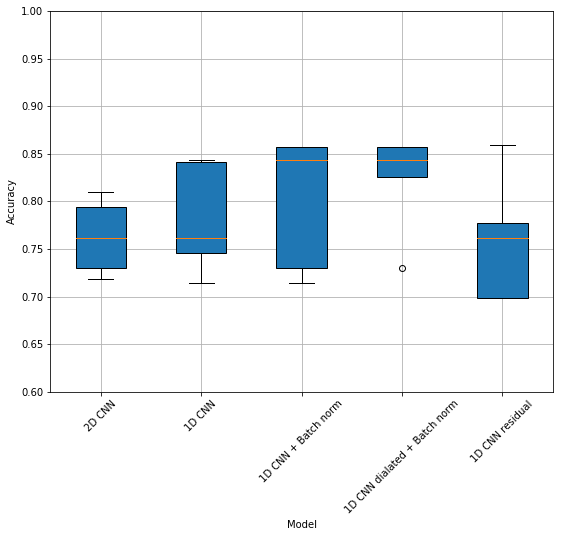

In [89]:
plt.figure(figsize=(9, 7))
ax = plt.axes()
plt.grid()

model_names = []
model_scores = []
for model_name in cross_val_scores:
    model_names.append(model_name)
    model_scores.append(cross_val_scores[model_name])

ax.boxplot(model_scores, patch_artist=True)
ax.set_ylabel("Accuracy")
ax.set_xlabel("Model")
_ = ax.set_xticklabels(model_names, rotation=45)
ax.set_ylim(0.6, 1)

plt.savefig("img/cross_val_scores")

### Plot the train and test losses for `CNN_1D_BatchNorm_Dial`

In [13]:
params, crossval_scores = load_best_params_and_scores(CNN_1D_BatchNorm_Dial)

X_tr, y_tr = CNN_1D_BatchNorm_Dial.prepare_data(train)
X_tr, y_tr = X_tr.to(device), y_tr.to(device)

X_te, y_te = CNN_1D_BatchNorm_Dial.prepare_data(test)
X_te, y_te = X_te.to(device), y_te.to(device)

model = CNN_1D_BatchNorm_Dial(**params)
model.to(device)

model.fit(X_tr, y_tr, X_te, y_te, epochs=60, callbacks=[keep_best_model], verbose=False)
print("Test score:", model.score(X_te, y_te))

/cvlabdata1/home/sacchi/others/predict-finger-movement/modelWrapper.py:126: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  sum_loss_train += loss.data[0].item()


Test score: 0.76


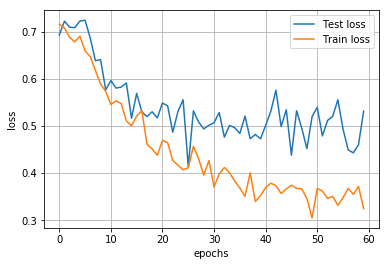

In [14]:
epochs = list(range(len(model.history.test_losses)))
plt.plot(epochs, model.history.test_losses, label='Test loss')
plt.plot(epochs, model.history.train_losses, label='Train loss')
plt.grid()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()

plt.savefig("img/train_test_losses")

### Show train loss with different oprìtimizers

In [7]:
params, crossval_scores = load_best_params_and_scores(CNN_1D_BatchNorm_Dial)

X_tr, y_tr = CNN_1D_BatchNorm_Dial.prepare_data(train)
X_tr, y_tr = X_tr.to(device), y_tr.to(device)

X_te, y_te = CNN_1D_BatchNorm_Dial.prepare_data(test)
X_te, y_te = X_te.to(device), y_te.to(device)
params

{'activation': torch.nn.modules.activation.Tanh,
 'dropout': 0.3,
 'nb_hidden': 40,
 'nb_layers': 4,
 'optimizer': torch.optim.adamax.Adamax,
 'weight_decay': 0.04978706836786395}

In [8]:
train_losses = {}

print("Training with Adam...")
params['optimizer'] = optim.Adam
model = CNN_1D_BatchNorm_Dial(**params)
model.to(device)
model.fit(X_tr, y_tr, epochs=60, verbose=False)
train_losses["Adam"] = model.history.train_losses

print("Training with Adadelta...")
params['optimizer'] = optim.Adadelta
model = CNN_1D_BatchNorm_Dial(**params)
model.to(device)
model.fit(X_tr, y_tr, epochs=60, verbose=False)
train_losses["Adadelta"] = model.history.train_losses

print("Training with Adamax...")
params['optimizer'] = optim.Adamax
model = CNN_1D_BatchNorm_Dial(**params)
model.to(device)
model.fit(X_tr, y_tr, epochs=60, verbose=False)
train_losses["Adamax"] = model.history.train_losses

Training with Adam...


/cvlabdata1/home/sacchi/others/predict-finger-movement/modelWrapper.py:126: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  sum_loss_train += loss.data[0].item()


Training with Adadelta...
Training with Adamax...


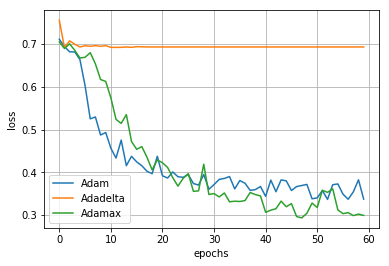

In [12]:
epochs = list(range(len(train_losses["Adam"])))
plt.plot(epochs, train_losses["Adam"], label='Adam')
plt.plot(epochs, train_losses["Adadelta"], label='Adadelta')
plt.plot(epochs, train_losses["Adamax"], label='Adamax')
plt.grid()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()

plt.savefig("img/optimizers")